# Alzheimer's Disease Classification

Author: **Marcin Sikorski**<br>
Date: May, 2023

**Introduction**<br>
Alzheimer’s disease is a condition where neurons within the brain stop functioning, lose connection with other neurons and die. It is the most common cause of dementia, a loss of brain function that can adversely impact memory, thinking, language, judgment and behavior. Alzheimer’s is neurodegenerative, irreversible, and progressive. There is no cure for this disorder but physicians can diagnose it at a very early stage, slow down the development, and improve patient's overall life quality. According to the World Health Organization (WHO), Alzheimer's is a disease of affluence, which means their will be a greater demand for neuro specialists in the future.

Alzheimer’s disease is evaluated by identifying certain symptoms and ruling out other possible causes of dementia. One of the most commonly accepted methods of tracking it is using neuroimaging, such as magnetic resonance imaging (MRI) or positron emission tomography (PET). MRI scans can provide incredibly detailed images that can be used to track many varieties of degenerative diseases. They use magnets and radio sound waves to create an image of the patient’s brain. It is worth mentioning that machine and deep learning techniques have been successfully applied in recent years to a wide range of medical imaging tasks. These techniques have the ability to automatically learn and extract features from large datasets, making them well suited for the analysis of complex medical images.

**Keywords:** Alzheimer's disease, multi-classification, machine learning, deep learning, MRI data, healthcare.

**Purpose**<br>
The main motive behind this project is to develop accurate models or frameworks for the classification of Alzheimer's disease. We will go through diverse machine learning models and observe which works best. This study was performed on MRI brain scans from [Kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset). The dataset contains 6400 images resized into 128 x 128 pixels.

**Notebook Content:**
1. Dataset Distribution and Exploration
2. Visualizing Dataset Samples
3. Machine Learning Models<br>
    3a. Preprocessing Images For ML<br>
    3b. SVC<br>
    3c. Random Forest<br>
    3d. kNN
4. Convolutional Neural Network Models<br>
    4a. Preprocessing Images For CNN<br>
    4b. EfficientNetB0<br>
    4c. InceptionV3<br>
    4d. Customized
5. Conclusions    

### 1. Dataset Distribution and Exploration

We will start from importing the modules and exploring the dataset. We will take a closer overview to the target labels and images in terms of quantity.

In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt

# set lists of paths to samples for each target label
mild = glob(r'C:\Users\...\Dataset\Mild_Demented\*.jpg')
very_mild = glob(r'C:\Users\...\Dataset\Very_Mild_Demented\*.jpg')
moderate = glob(r'C:\Users\...\Dataset\Moderate_Demented\*.jpg')
non = glob(r'C:\Users\...\Dataset\Non_Demented\*.jpg')

# main path to dataset
path = r'C:\Users\...\Dataset'

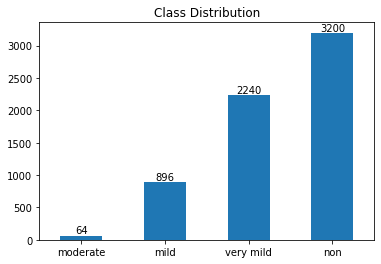

In [2]:
# display quantity of images (labels)
def count_images():
    lists = [mild, moderate, very_mild, non]
    labels = ['moderate', 'mild', 'very mild', 'non']
    count_list = []
    
    # new list of counts
    for i in lists:
        count_list.append(len(i))
    
    count_list.sort()
    
    from pandas import DataFrame

    df = DataFrame(zip(labels, count_list), columns=['class', 'count']).set_index('class')
    df.sort_values(by='count', ascending=True).plot.bar(title='Class Distribution', legend=None)
    plt.xticks(rotation=0)
    plt.xlabel(None)
    for i in range(len(count_list)):
        plt.text(i, count_list[i], count_list[i], ha='center', va='bottom')
    plt.show()
    
count_images()

This dataset looks very unbalanced and the distribution of discrete values is very different. This can cause the machine learning algorithms to get biased towards the majority values present and not perform well on the minority values and therefore decrease their accuracy. We can fix this issue by finding weights for each class. Higher weights are then usually assigned to classes with lower distribution. Each class weight can be calculated with formula:

$$w_i = \frac{n_{samples}}{n_{classes} \times n_{samples_{i}}},$$

where:

* $w_i$ is the weight for given $i$ class,
* $n_{samples}$ is the total number of samples in the dataset,
* $n_{classes}$ is the number of all unique classes in the target,
* $n_{samples_{i}}$ is the total number of samples of the given class.

In [3]:
# calculate weights for each class
def extract_class_weights():
    class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
    
    # count samples per class and store in dictionary
    class_counts = dict()
    for name in class_names:
        class_counts[name] = len(os.listdir(path + '/' + name))
    
    # total number of samples and number of classes
    total = sum(class_counts.values())
    num_classes = len(class_names)
    
    # calculate weights for each class
    class_weights = dict()
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * list(class_counts.values())[i])
        print('{} {}: {:.2}'.format(i+1, class_names[i], class_weights[i]))
        
    return class_weights

extract_class_weights()

1 Mild_Demented: 1.8
2 Moderate_Demented: 2.5e+01
3 Non_Demented: 0.5
4 Very_Mild_Demented: 0.71


{0: 1.7857142857142858, 1: 25.0, 2: 0.5, 3: 0.7142857142857143}

These weights will be implemented to our further predictive models.

### 2. Visualizing Dataset Samples

We will display 6 random images for each label.

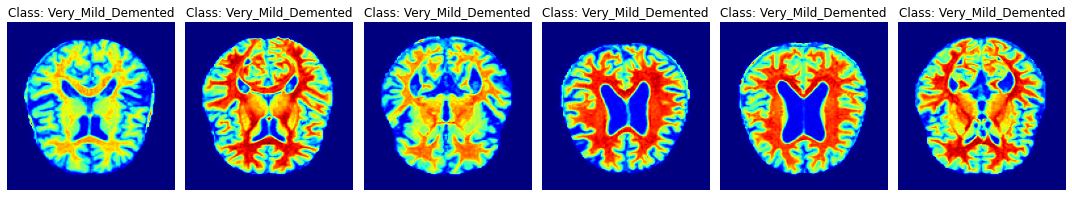

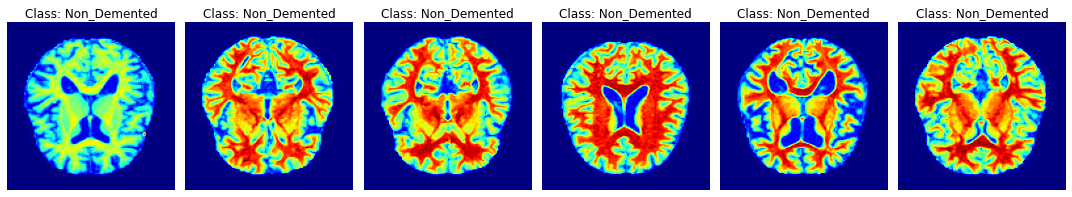

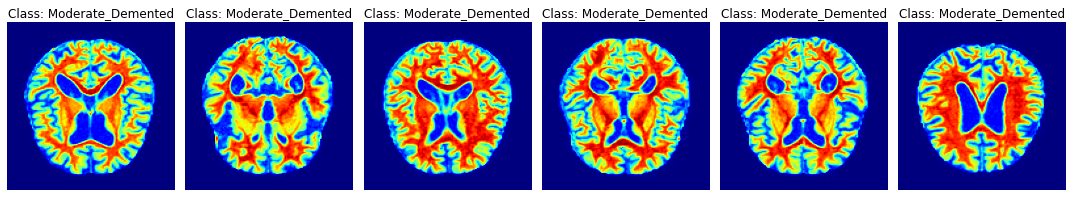

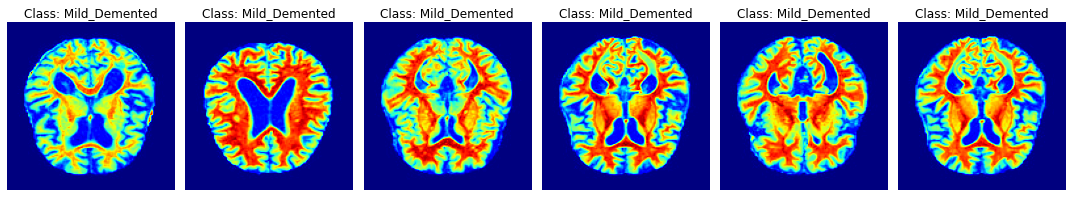

In [4]:
# show random MRI scans
def display_images(label):
    """
    Parameters:
    ----------
    label: list(str)
        list of paths to images
    """
    import random
    from matplotlib.image import imread
    from pathlib import PurePath
    
    fig, axs = plt.subplots(1, 6, figsize=(15, 3), tight_layout=True)
    axs = axs.ravel()
    
    # list of random images
    img_list = random.sample(label, 6)
    
    for i, img_path in enumerate(img_list):
        img = imread(img_path)
        label = PurePath(img_path).parent.name
        axs[i].set_title(f'Class: {label}', fontsize=12)
        axs[i].imshow(img, cmap='jet')
        axs[i].axis('off')
    plt.show()
    
display_images(very_mild)
display_images(non)
display_images(moderate)
display_images(mild)

Patients with dementia have brain atrophy. They tend to have less gray matter and enlarged ventricles (that lies in the center of the brain). The models will most likely focus on areas in the brains with volume decline and thinner cortical gray area.

### 3. Machine Learning Models

### 3a. Preprocessing Images For ML

We will perform classification with <code>scikit-learn</code> algorithms. First, we must convert PIL images into arrays to make them readable for the models. The images will be resized into larger dimension to keep information of each of them. Adding pixels should not slow down the learning process significantly. Next, we will split the dataset into training and testing sets with 80:20 ratio.

In [5]:
import numpy as np

# list to store flatten arrays
resized_image_array = []
# list to store labels
resized_image_array_label = []

# resize images to 256 x 256, convert to NumPy array, and stack into lists
def resize_images(image_directory):
    """
    Parameters:
    ----------
    image_directory: list(str)
        list of paths to images
    """
    from PIL import Image
    
    target_size = (256, 256)
    
    for file in image_directory:
        img = Image.open(file)
        
        # preserve aspect ratio
        img = img.resize(target_size)
        array_temp = np.array(img)
        
        # reshape and flatten images
        shape_new = 256 * 256
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        
        # arrays of labels
        if image_directory == non:
            resized_image_array_label.append(0)
        elif image_directory == very_mild:
            resized_image_array_label.append(1)
        elif image_directory == mild:
            resized_image_array_label.append(2)
        elif image_directory == moderate:
            resized_image_array_label.append(3)
            
# run function for each class
resize_images(non)
resize_images(mild)
resize_images(very_mild)
resize_images(moderate)

# split data to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resized_image_array, resized_image_array_label,
                                                    train_size=0.8, shuffle=True, random_state=42)

# display number of samples per set
print('Train images:', len(X_train))
print('Test images:', len(X_test))

Train images: 5120
Test images: 1280


The data is ready for the next step. We will apply for each ML model the dictionary of class weights: <code>{class_label: weight, ..}</code>. Finally, an evaluation of the performance will be made using accuracies and F1 scores for the test subset. To visualize label classification, we will generate confusion matrices and some examples of misclassified images.

### 3b. SVC

In [6]:
# initiate dictionaries with accuracies
# initiate list of models
accuracies = dict()
classifiers = []

def svc_classifier():
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, f1_score
    
    # SVC classifier with class weights
    svc_clf = SVC(kernel='linear', probability=True, class_weight={0: 1.8, 1: 2.5, 2: 0.5, 3: 0.71})
    svc_clf.fit(X_train, y_train)
    
    y_pred = svc_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test accuracy: {:.4f}'.format(acc))
    print('Test F1 score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('Misclassified images: {} out of {}'.format((y_test != y_pred).sum(), len(y_test)))
    
    classifiers.append(svc_clf)
    accuracies['SVC'] = acc
    
svc_classifier()

Test accuracy: 0.9914
Test F1 score: 0.9914
Misclassified images: 11 out of 1280


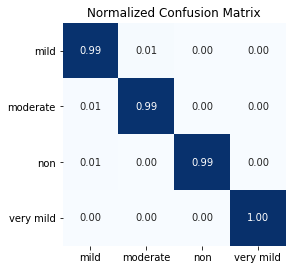

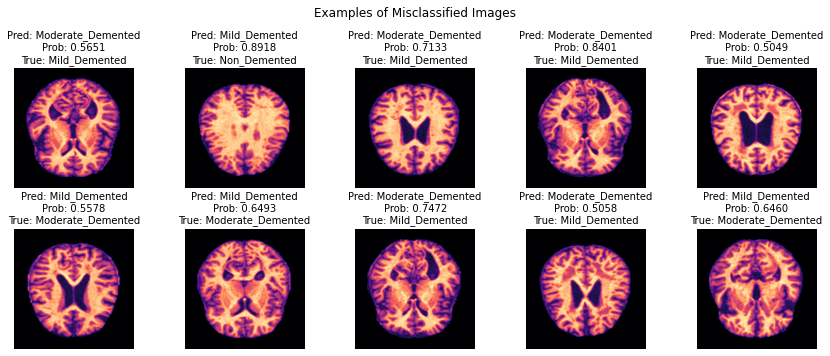

In [7]:
# display confusion matrix and misclassified images
def plot_confusion_matrix(classifier, normalize=True):
    """
    Parameters:
    ----------
    classifier: sklearn model
        scikit-learn multi-label classifier
    normalize: boolean (default `True`)
        if `True` values will be normalized, if `False` values will be counts
    """
    # make predictions and get probabilities
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test).max(axis=1)
    
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    # plot confusion matrix
    plt.figure(figsize=(4, 5))
    class_labels = ['mild', 'moderate', 'non', 'very mild']
    
    if normalize:
        # heatmap properties
        hm_kwargs = dict(cmap='Blues', square=True, annot=True, fmt='.2f', cbar=False,
                         xticklabels=class_labels, yticklabels=class_labels)
    
        confu_matrix = confusion_matrix(y_test, y_pred.astype(int), normalize='true')
        heatmap(data=confu_matrix, **hm_kwargs)
        plt.title('Normalized Confusion Matrix')
        plt.yticks(rotation=0) 
        plt.show()
        
    else:
        # heatmap properties
        hm_kwargs = dict(cmap='Blues', square=True, annot=True, fmt='d', cbar=False,
                         xticklabels=class_labels, yticklabels=class_labels)
    
        confu_matrix = confusion_matrix(y_test, y_pred.astype(int))
        heatmap(data=confu_matrix, **hm_kwargs)
        plt.title('Confusion Matrix')
        plt.yticks(rotation=0) 
        plt.show()
        
    # plot samples of incorrectly classified images
    from matplotlib.image import imread
    import random
        
    # get the indices and labels of incorrectly classified images
    incorrect_indx = np.nonzero(y_pred != y_test)[0]
    false_class = list(zip(np.array(X_test)[incorrect_indx], y_pred[incorrect_indx], y_proba[incorrect_indx],
                           np.array(y_test)[incorrect_indx]))
        
    class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
        
    fig, axs = plt.subplots(2, 5, figsize=(12, 5), tight_layout=True)
    fig.suptitle('Examples of Misclassified Images', fontsize=12)
    axs = axs.ravel()
        
    # reorganize the order of the items
    random.shuffle(false_class)
        
    for i in range(0, 10):
        axs[i].set_title('Pred: {}\nProb: {:.4f}\nTrue: {}'.format(class_names[false_class[i][1]], false_class[i][2],
                                                                     class_names[false_class[i][3]]), fontsize=10)
        axs[i].imshow(np.reshape(false_class[i][0], (-1, 256)), cmap='magma')
        axs[i].axis('off')
    plt.show()
        
plot_confusion_matrix(classifier=classifiers[-1])

### 3c. Random Forest

Test accuracy: 0.9313
Test F1 score: 0.9286
Misclassified images: 88 out of 1280


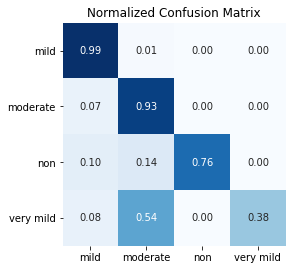

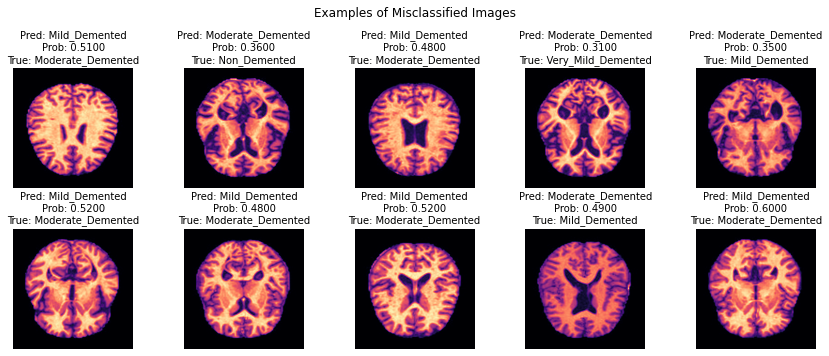

In [8]:
def random_forest_classifier():
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, f1_score
    
    # random forest classifier with class weights
    rf_clf = RandomForestClassifier(n_estimators=100, class_weight={0: 1.8, 1: 2.5, 2: 0.5, 3: 0.71})
    rf_clf.fit(X_train, y_train)
    
    y_pred = rf_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test accuracy: {:.4f}'.format(acc))
    print('Test F1 score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('Misclassified images: {} out of {}'.format((y_test != y_pred).sum(), len(y_test)))
    
    classifiers.append(rf_clf)
    accuracies['Random Forest'] = acc
    
random_forest_classifier()
plot_confusion_matrix(classifier=classifiers[-1])

### 3d. kNN

Test accuracy: 0.9531
Test F1 score: 0.9529
Misclassified images: 60 out of 1280


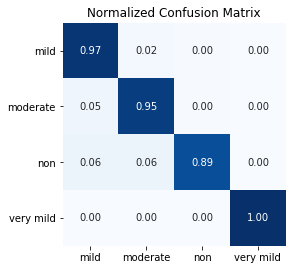

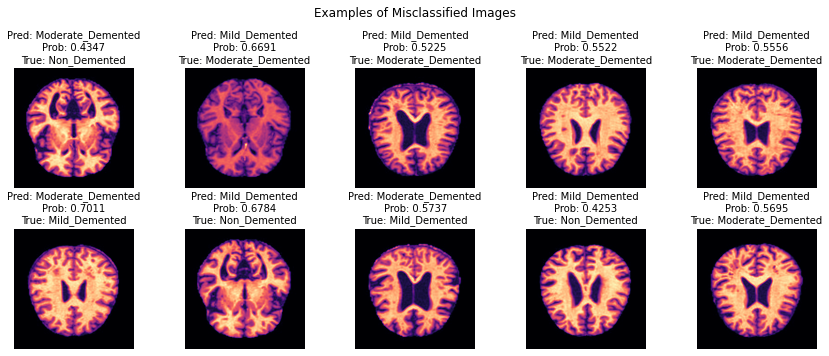

In [9]:
def knn_classifier():
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score, f1_score
    
    # set distance function to apply weights
    def distance_func(weights=[1.8, 2.5, 0.5, 0.71]):
        return weights
    
    # kNN classifier with class weights
    knn_clf = KNeighborsClassifier(n_neighbors=5, weights=distance_func)
    knn_clf.fit(X_train, y_train)
    
    y_pred = knn_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test accuracy: {:.4f}'.format(acc))
    print('Test F1 score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('Misclassified images: {} out of {}'.format((y_test != y_pred).sum(), len(y_test)))
    
    classifiers.append(knn_clf)
    accuracies['kNN'] = acc
    
knn_classifier()
plot_confusion_matrix(classifier=classifiers[-1])

We trained all <code>scikit-learn</code> classifiers, each with very high performance. For the next step we will develop 
convolutional neural networks for detecting Alzheimer's disease in <code>TensorFlow</code> framework.

### 4. Convolutional Neural Network Models

### 4a. Preprocessing Images For CNN

We will split the data into training and validation subsets with previous 80:20 ratio. The evaluation of each network will be measured with accuracy and loss. Two pre-trained models will be implemented and a customized model with new architecture. The training will be visualized using learning curves and label classification with confusion matrices. We will plot some examples of misclassified images.

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
tf.random.set_seed(seed=0)

# generate train dataset
train_data = image_dataset_from_directory(directory=path,
                                          label_mode='categorical',
                                          color_mode='rgb',
                                          image_size=(128, 128),
                                          batch_size=32,
                                          shuffle=True,
                                          validation_split=0.2,
                                          subset='training',
                                          seed=0)

# generate complete validation dataset
full_val_data = image_dataset_from_directory(directory=path,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             image_size=(128, 128),
                                             batch_size=32,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=0)

# display labels
print('\nClass names:', train_data.class_names)

# display number of batches in 'full_val_data'
print('\nTotal number of batches:', len(full_val_data))

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.

Class names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

Total number of batches: 40


We need to split the full validation dataset into testing and validation subsets. Each will have size of 20 batches.

In [11]:
test_data = full_val_data.skip(len(full_val_data) // 2)
print('Batches in test dataset:', len(test_data))

validation_data = full_val_data.take(len(full_val_data) // 2)
print('Batches in validation dataset:', len(validation_data))

for img_batch, labels_batch in train_data:
    img_shape = img_batch.shape
    print('\nImage batch shape: {}'.format(img_shape))
    print('Label batch shape: {}'.format(labels_batch.shape))
    break

Batches in test dataset: 20
Batches in validation dataset: 20

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


### 4b. EfficientNetB0

In [12]:
# clear session, avoid clutter from old models and layers
from tensorflow.keras import backend
backend.clear_session()

def efficientnet0_classifier():
    from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
    from tensorflow.keras import Sequential, Input, Model
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
    
    base_model = EfficientNetB0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    
    # freeze weights in pre-trained network
    for layer in base_model.layers[0:218]:
        layer.trainable = False
    
    # model setup
    inputs = Input(shape=(128, 128, 3), name='input_layer')
    x = preprocess_input(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
    outputs = Dense(units=4, activation='softmax', name='predictions')(x)
    model = Model(inputs, outputs, name='EfficientNetB0')
    
    from tensorflow.keras.losses import CategoricalCrossentropy
    from tensorflow.keras.optimizers import Adam
    
    # set Adam optimizer, evaluation metric and compile CNN
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

# define CNN
EffNet0_mod = efficientnet0_classifier()

# display the network's architecture
EffNet0_mod.summary()

# show number of layers
print('\nNumber of layers:', len(EffNet0_mod.layers))

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 predictions (Dense)         (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 1,134,900
Non-trainable params: 2,919,795
_________________________________________________________________

Number of layers: 4


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

# train EfficientNetB0 model
EffNet0_history = EffNet0_mod.fit(train_data,
                                  validation_data=validation_data,
                                  epochs=40,
                                  verbose=True,
                                  class_weight={0: 1.8, 1: 2.5, 2: 0.5, 3: 0.71},
                                  callbacks=[early_stopping],
                                  use_multiprocessing=True)

# add classifier to list
classifiers.append(EffNet0_mod)

Epoch 1/40
160/160 [==============================] - 57s 327ms/step - loss: 0.7616 - accuracy: 0.5518 - val_loss: 0.7660 - val_accuracy: 0.6516
Epoch 2/40
160/160 [==============================] - 51s 321ms/step - loss: 0.5227 - accuracy: 0.6854 - val_loss: 0.6616 - val_accuracy: 0.7250
Epoch 3/40
160/160 [==============================] - 51s 320ms/step - loss: 0.3986 - accuracy: 0.7639 - val_loss: 0.5008 - val_accuracy: 0.7844
Epoch 4/40
160/160 [==============================] - 52s 323ms/step - loss: 0.2981 - accuracy: 0.8324 - val_loss: 0.4329 - val_accuracy: 0.8250
Epoch 5/40
160/160 [==============================] - 52s 324ms/step - loss: 0.2499 - accuracy: 0.8605 - val_loss: 0.3560 - val_accuracy: 0.8687
Epoch 6/40
160/160 [==============================] - 52s 323ms/step - loss: 0.1988 - accuracy: 0.8879 - val_loss: 0.3299 - val_accuracy: 0.8891
Epoch 7/40
160/160 [==============================] - 52s 323ms/step - loss: 0.1633 - accuracy: 0.9072 - val_loss: 0.3934 - val_ac

In [14]:
# evaluate CNN performance
def evaluate_cnn(classifier, label):
    """
    Parameters:
    ----------
    classifier: keras model
        keras multi-label classifier (CNN)
    label: str
        classifier label for dictionary
    """
    val_loss, val_accuracy = classifier.evaluate(validation_data, verbose=1)
    print('\nValidation loss: {:.4f}'.format(val_loss))
    print('Validation accuracy: {:.4f}'.format(val_accuracy))
    
    num_misclass = int((1 - val_accuracy) * len(validation_data) * 32)
    print('Misclassified images: {} out of {}'.format(num_misclass, len(validation_data) * 32))
    
    accuracies[label] = val_accuracy
    
evaluate_cnn(classifier=classifiers[-1], label='EffNet0_CNN')

20/20 [==============================] - 5s 259ms/step - loss: 0.1689 - accuracy: 0.9453

Validation loss: 0.1689
Validation accuracy: 0.9453
Misclassified images: 35 out of 640


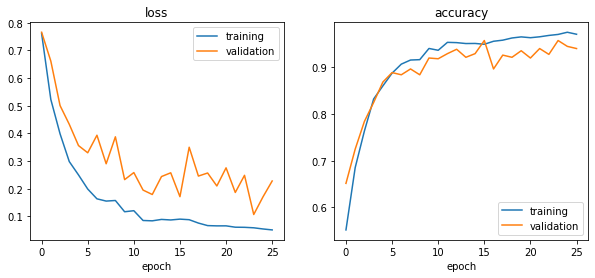

In [15]:
# show learning curves
def diagnosis_plots(history):
    """
    Parameters:
    ----------
    history: keras callbacks
        keras history of callbacks and metrics for each epoch
    """
    metric_list = ['loss', 'accuracy']
    
    plt.figure(figsize=(10, 4))
    
    for i, metric in enumerate(metric_list):   
        plt.subplot(1, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='training')
        plt.plot(history.epoch, history.history['val_'+ metric], label='validation')
        plt.legend(loc='best')
        plt.title(metric)
        plt.xlabel('epoch')
    plt.show()

diagnosis_plots(history=EffNet0_history)

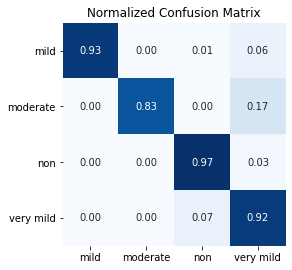

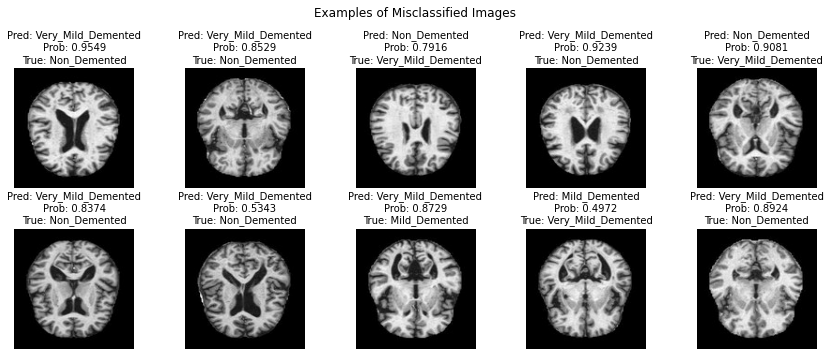

In [16]:
# display confusion matrix for CNN
def plot_confusion_matrix_cnn(classifier, normalize=True):
    """
    Parameters:
    ----------
    classifier: keras model
        keras multi-label classifier (CNN)
    normalize: boolean (default `True`)
        if `True` values will be normalized, if `False` values will be counts
    """
    # set empty lists to store images and labels
    val_images = []
    val_labels = []
    
    # iterate through the val dataset and append each batch to a list
    for batch in validation_data.as_numpy_iterator():
        val_images.append(batch[0])
        val_labels.append(batch[1])
    
    # stack batches into a single array for both images and labels
    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    
    # get actual class labels
    y_true = np.array(val_labels)
    y_true = tf.argmax(y_true, axis=1).numpy()
    
    # make predictions and convert predicted probabilities into class labels
    y_proba = classifier.predict(val_images)
    y_pred = tf.argmax(y_proba, axis=1).numpy()
    
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    # plot confusion matrix
    plt.figure(figsize=(4, 5))
    class_labels = ['mild', 'moderate', 'non', 'very mild']
    
    if normalize:
        # heatmap properties
        hm_kwargs = dict(cmap='Blues', square=True, annot=True, fmt='.2f', cbar=False,
                         xticklabels=class_labels, yticklabels=class_labels)
    
        confu_matrix = confusion_matrix(y_true, y_pred, normalize='true')
        heatmap(data=confu_matrix, **hm_kwargs)
        plt.title('Normalized Confusion Matrix')
        plt.yticks(rotation=0) 
        plt.show()
        
    else:
        # heatmap properties
        hm_kwargs = dict(cmap='Blues', square=True, annot=True, fmt='d', cbar=False,
                         xticklabels=class_labels, yticklabels=class_labels)
    
        confu_matrix = confusion_matrix(y_true, y_pred)
        heatmap(data=confu_matrix, **hm_kwargs)
        plt.title('Confusion Matrix')
        plt.yticks(rotation=0) 
        plt.show()
    
    # plot samples of incorrectly classified images
    from matplotlib.image import imread
    import random
    
    # get the indices and labels of incorrectly classified images
    incorrect_indx = np.nonzero(y_pred != y_true)[0]
    false_class = list(zip(val_images[incorrect_indx], y_pred[incorrect_indx],
                           y_proba.max(axis=1)[incorrect_indx], y_true[incorrect_indx]))
    
    class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
    
    fig, axs = plt.subplots(2, 5, figsize=(12, 5), tight_layout=True)
    fig.suptitle('Examples of Misclassified Images', fontsize=12)
    axs = axs.ravel()
    
    # reorganize the order of the items
    random.shuffle(false_class)
    
    for i in range(0, 10):
        axs[i].set_title('Pred: {}\nProb: {:.4f}\nTrue: {}'.format(class_names[false_class[i][1]], false_class[i][2],
                                                                     class_names[false_class[i][3]]), fontsize=10)
        axs[i].imshow(false_class[i][0].astype('uint16'))
        axs[i].axis('off')
    plt.show()
        
plot_confusion_matrix_cnn(classifier=classifiers[-1])

### 4c. InceptionV3

In [17]:
# clear previous session
backend.clear_session()

def inception_classifier():
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    from tensorflow.keras import Sequential, Input, Model
    from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
    
    base_model = InceptionV3(input_shape=(128, 128, 3), include_top=False, weights ='imagenet')
    
    # freeze weights in pre-trained network
    for layer in base_model.layers:
        layer.trainable = False
    
    # model setup
    model = Sequential(
        [
            base_model,
            Flatten(),
            Dense(units=1024, activation='relu'),
            Dense(units=4, activation='softmax', name='predictions')
        ], name='InceptionV3'
    )
    
    from tensorflow.keras.losses import CategoricalCrossentropy
    from tensorflow.keras.optimizers import Adam
    
    # set Adam optimizer, evaluation metric and compile CNN
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

# define CNN
Incep3_mod = inception_classifier()

# display the network's architecture
Incep3_mod.summary()

# show number of layers
print('\nNumber of layers:', len(Incep3_mod.layers))

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 predictions (Dense)         (None, 4)                 4100      
                                                                 
Total params: 30,196,516
Trainable params: 8,393,732
Non-trainable params: 21,802,784
_________________________________________________________________

Number of layers: 4


In [18]:
# train InceptionV3 model
Incep3_history = Incep3_mod.fit(train_data,
                               validation_data=validation_data,
                               epochs=40,
                               verbose=True,
                               class_weight={0: 1.8, 1: 2.5, 2: 0.5, 3: 0.71},
                               callbacks=[early_stopping])

# add classifier to list
classifiers.append(Incep3_mod)

Epoch 1/40
160/160 [==============================] - 49s 291ms/step - loss: 99.9066 - accuracy: 0.4232 - val_loss: 25.3108 - val_accuracy: 0.4891
Epoch 2/40
160/160 [==============================] - 46s 287ms/step - loss: 14.6765 - accuracy: 0.5057 - val_loss: 8.6707 - val_accuracy: 0.4563
Epoch 3/40
160/160 [==============================] - 47s 290ms/step - loss: 5.0562 - accuracy: 0.5373 - val_loss: 2.6757 - val_accuracy: 0.5281
Epoch 4/40
160/160 [==============================] - 47s 294ms/step - loss: 1.7129 - accuracy: 0.5914 - val_loss: 2.1664 - val_accuracy: 0.5016
Epoch 5/40
160/160 [==============================] - 47s 292ms/step - loss: 0.8698 - accuracy: 0.6352 - val_loss: 1.0596 - val_accuracy: 0.6187
Epoch 6/40
160/160 [==============================] - 47s 295ms/step - loss: 0.8262 - accuracy: 0.6408 - val_loss: 1.5041 - val_accuracy: 0.5516
Epoch 7/40
160/160 [==============================] - 47s 292ms/step - loss: 0.9651 - accuracy: 0.6203 - val_loss: 0.9113 - val

20/20 [==============================] - 5s 243ms/step - loss: 0.7980 - accuracy: 0.6656

Validation loss: 0.7980
Validation accuracy: 0.6656
Misclassified images: 214 out of 640


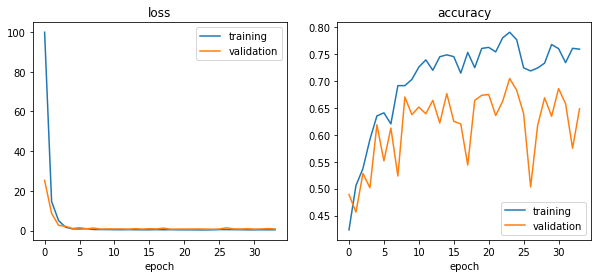

In [19]:
evaluate_cnn(classifier=classifiers[-1], label='Incep3_CNN')
diagnosis_plots(history=Incep3_history)

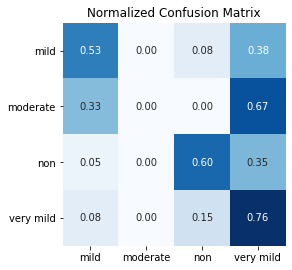

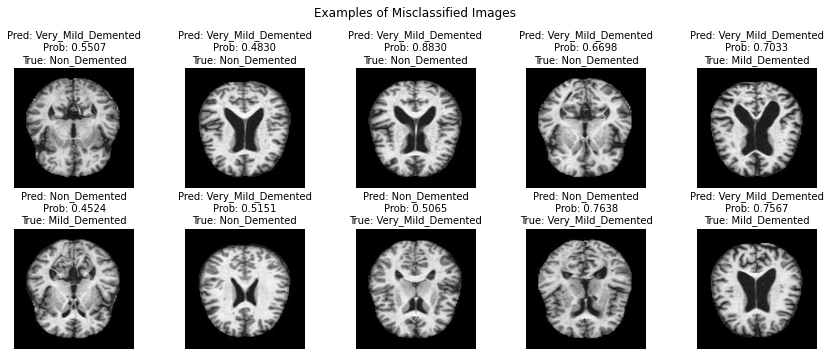

In [20]:
plot_confusion_matrix_cnn(classifier=classifiers[-1])

### 4d. Customized

Last ConvNet model will be customized with a new architecture from scratch. For a non-binary classification, we will apply categorical cross-entropy and the softmax function for the final layer.

In [21]:
backend.clear_session()

def custom_classifier():
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers.experimental.preprocessing import Rescaling
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
    
    model = Sequential(
        [
            Rescaling(1./255, input_shape=(128, 128, 3), name='input_layer'),
            Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.2),
            
            Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.2),
            
            Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            
            Flatten(),
            Dense(units=128, activation='relu', kernel_initializer='he_normal'),
            Dense(units=64, activation='relu'),
            Dense(units=4, activation='softmax', name='predictions')
        ], name='custom'
    )
    
    from tensorflow.keras.losses import CategoricalCrossentropy
    from tensorflow.keras.optimizers import Adam
    
    # set Adam optimizer, evaluation metric and compile CNN
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

# define CNN
custom_mod = custom_classifier()

# display the network's architecture
custom_mod.summary()

# show number of layers
print('\nNumber of layers:', len(custom_mod.layers))

Model: "custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0    

In [22]:
# train customized model
custom_history = custom_mod.fit(train_data,
                                validation_data=validation_data,
                                epochs=40,
                                verbose=True,
                                class_weight={0: 1.8, 1: 2.5, 2: 0.5, 3: 0.71},
                                callbacks=[early_stopping])

# add classifier to list
classifiers.append(custom_mod)

Epoch 1/40
160/160 [==============================] - 28s 171ms/step - loss: 0.9786 - accuracy: 0.3568 - val_loss: 1.1628 - val_accuracy: 0.3344
Epoch 2/40
160/160 [==============================] - 27s 169ms/step - loss: 0.9075 - accuracy: 0.4113 - val_loss: 1.0317 - val_accuracy: 0.5000
Epoch 3/40
160/160 [==============================] - 27s 170ms/step - loss: 0.8256 - accuracy: 0.4980 - val_loss: 0.9397 - val_accuracy: 0.5344
Epoch 4/40
160/160 [==============================] - 27s 169ms/step - loss: 0.7655 - accuracy: 0.5229 - val_loss: 0.9127 - val_accuracy: 0.5437
Epoch 5/40
160/160 [==============================] - 27s 169ms/step - loss: 0.7198 - accuracy: 0.5420 - val_loss: 0.8010 - val_accuracy: 0.6156
Epoch 6/40
160/160 [==============================] - 27s 169ms/step - loss: 0.6590 - accuracy: 0.5936 - val_loss: 1.0370 - val_accuracy: 0.4906
Epoch 7/40
160/160 [==============================] - 27s 169ms/step - loss: 0.6136 - accuracy: 0.6156 - val_loss: 0.7077 - val_ac

20/20 [==============================] - 1s 50ms/step - loss: 0.0623 - accuracy: 0.9828

Validation loss: 0.0623
Validation accuracy: 0.9828
Misclassified images: 10 out of 640


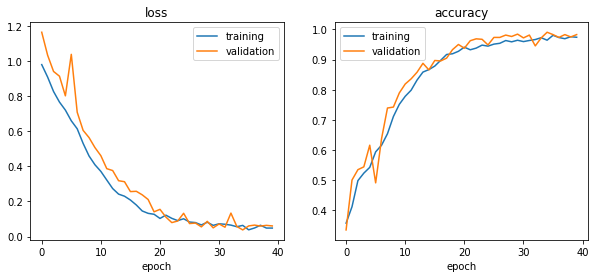

In [23]:
evaluate_cnn(classifier=classifiers[-1], label='Custom_CNN')
diagnosis_plots(history=custom_history)

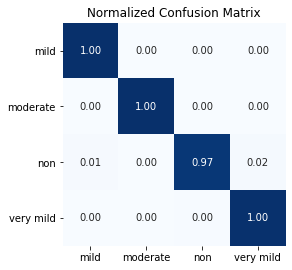

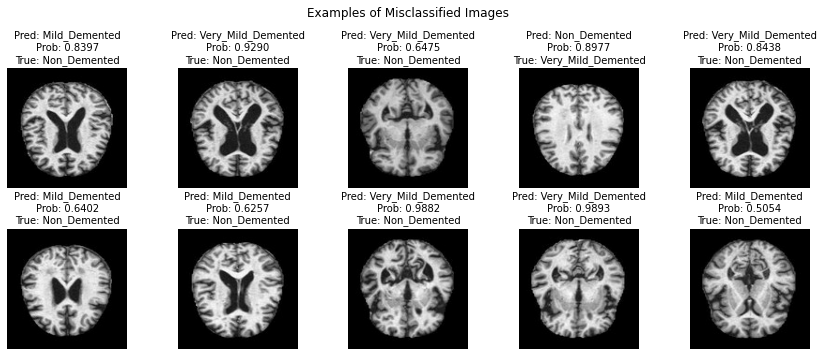

In [24]:
plot_confusion_matrix_cnn(classifier=classifiers[-1])

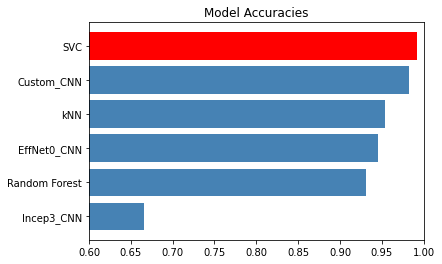

In [25]:
# plot achieved accuracies for each classifier
def plot_accuracies():
    # sort dictionary descending by values
    acc_sorted = sorted(accuracies.items(), key=lambda x: x[1], reverse=False)
    
    # extract values into lists
    acc_values = [x[1] for x in acc_sorted]
    acc_keys = [x[0] for x in acc_sorted]
    
    colors = ['red' if (bar == max(acc_values)) else 'steelblue' for bar in list(acc_values)]
    plt.barh(acc_keys, acc_values, align='center', color=colors)
    plt.title('Model Accuracies')
    plt.xlim([0.6, 1])
    plt.show()
    
plot_accuracies()

The support vector classification model is the most recommended for this dataset, since it has the highest accuracy with almost 100%. The InceptionV3 classifier has probably the most surprising performance and is not worth considering. It is possible that this model needs a different architecture. Excluding the InceptionV3 network, all classifiers are very promising. Having the minimum 93% accuracy proves that the use of MRI scanning is very effective in identification of Alzheimer's disease.

### 5. Conclusions

This notebook aims to evaluate the performance of machine learning models in detecting and classifying Alzheimer's disease using MRI scan data of patient's brains. To complete this task, we built six diverse predictive models in <code>scikit-learn</code> and <code>TensorFlow</code> libraries. The common evaluation score for all classifiers was the accuracy.

The results obtained in the the four-class classification problem, demonstrate the potential of machine learning models for accurately detecting and differentiating between the different stages of Alzheimer's disease. Medical imaging proves to have important implications for early diagnosis and treatment.

For further optimization, we can implement an image augmentation pipeline in the training stage for each model, such as: image translation, scaling or vertical/horizontal flips. Collecting and analyzing patient's anatomical measures and demographic data (age, gender, socioeconomic status, education level, brain volume, etc.) within a separate dataset can also provide more insights and accurate diagnosis for each disorder case. Also, the dataset used in this study is relatively small, and it may not be representative of the entire population. This means we should increase the quantity of images for diverse social groups.

**References:**
1. Accurate Detection of Alzheimer’s Disease Using Lightweight Deep Learning Model on MRI Data (2023), [Full Text](https://www.mdpi.com/2075-4418/13/7/1216)
2. Early Detection of Alzheimer’s Disease Using Magnetic Resonance Imaging: A Novel Approach Combining Convolutional Neural Networks and Ensemble Learning (2020), [Full Text](https://www.frontiersin.org/articles/10.3389/fnins.2020.00259/full)
3. Using Transfer Learning to Classify Different Stages of Alzheimer's Disease (2021), [Full Text](https://www.diva-portal.org/smash/get/diva2:1593457/FULLTEXT01.pdf)